# Detección de Objetos

**Equipo:** Los máquinas

Integrantes:
- García Padilla Rodrigo

**Este notebook está pensado para correrse en kaggle ya que el dataset que ocupamos ya forma parte de kaggle. Si se quiere ejecutar aparte es necesario tener el archivo de anotaciones, una imagen de ejemplo, y modificar el valor de las variables ann_file y example_img por las rutas de estas. Si el proyecto se ejecuta en Kaggle hay que seleccionar la opción Data, Add Data, coco-2017-dataset.**

**Descripción del problema:**  
El problema que elegimos consiste en detección de objetos. Este problema pertenece al campo de visión computacional cuyo objetivo es identificar y localizar uno o varios objetos dentro de una imagen o un video, es decir, determinar las ubicaciones de los objetos dentro de la imagen y definir recuadros que encierren esos objetos, adicionalmente etiquetando estos recuadros acorde a las clases definidas. En ese sentido la detección de objetos se divide en dos problemas, uno perteneciente a regresión y otro que recibiendo retroalimentación de las cajas, se encarga de etiquetar cada una mediante clasificacióñ, nosotros nos centramos en el problema de encerrar objetos dentro de cuadros, y para acotar un poco más el problema dentro de nuestros alcances, decidimos que solo trabajaríamos con imágenes que tuvieran un único objeto.


**Dataset:**  
El dataset que nosotros seleccionamos es COCO (Common Objects in Context), específicamente el del año 2017; este es un conjunto de datos ampliamente utilizado en el campo de la visión por computadora y el reconocimiento de objetos. Fue creado para abordar distintas tareas, entre las cuales se encuentran: detección de objetos, segmentación de ejemplares, segmentación semántica, detección de keypoints, segmentación panóptica, 'dense pose', segmentaición de cosas en una imagen, etc.

Ya que el dataset sirve para muchas tareas distintas, hay mucha información que no vamos a ocupar; puesto que a nosotros solo nos interesa la detección de objetos, vamos a ocupar las imágenes del dataset y su archivo de anotaciones. El archivo de anotaciones del dataset es un archivo en formato json que contiene las anotaciones de cada imagen; una anotación es un diccionario que contiene la información correspondiente a un objeto dentro de una imagen, una imagen puede tener más de una anotación ya que puede contener más de un objeto. Entre la información que contiene una anotación se encuentra: id de la anotación, id de la imagen a la que pertenece, segmentación (que indica el poligono que delimita el objeto, es decir su máscara), bounded box (que indica la información del cuadro dentro del cual se encuentra el objeto), e id de la categoría del objeto. A nosotros nos interesa principalmente el contenido de bbox (bounded box), pues son los valores que describen el cuadro que encierra al objeto.  

COCO define un total de 91 categorías de objetos, sin embargo el dataset solo contiene ejemplos de 80 de estas categorías; algo muy importante a tener en cuenta es que las clases no están balanceadas, y que hay muchos más ejemplares de personas que de cualquier otra clase.

**Retos:**  
Al trabajar con tipos de datos no estructurados encontramos distintos problemas, el primero y más evidente es que las entradas son de tamaños variables; para que la red, y los batches puedan funcionar con todas las imágenes es necesario normalizar las imágenes de entrada. Otro problema al que nos enfrentamos es que las anotaciones también pueden tener tamaño variable en el caso en que una imagen contenga más de un objeto; esto lo solucionamos filtrando solo las imágenes que tuvieran un único objeto. Otro problema que tuvimos fue que la base de datos es muy pesada, la base de datos completa pesa más de 20 GB, hacer las pruebas sobre todo el dataset completo es muy costoso en tiempo, por esa cuando desarrollábamos este proyecto solo probabamos los módulos con el conjunto de validación, que tiene un tamaño mucho menor. En general el problema más común que tuvimos fue entre la compatibilidad de los tipos de datos y su tamaño.



## Redes R-CNN:

![](https://miro.medium.com/v2/resize:fit:1200/1*S_-8lv4zP3W8IVfGP6_MHw.jpeg)

Las redes convolucionales basadas en regiones, propuestas por Ross Girshick, consisten en usar la búsqueda selectiva para obtener propuestas de región a partir de las cuales discriminar.

Para ello se apoya de un algoritmo denominado búsqueda selectiva que consiste en segmentar la imagen en búsqueda de generar regiones candidatas las cuales luego pueda de manera greedy combinar estas regiones basado en similitud y finalmente obtener las segmentaciones finales.

Luego de obtenere las propuestas de región son deformadas a una imagen cuadrada, que tras ser introducida en una red convolucional es aplanada a un vector de características.
Finalmente este vector de características es dado como entrada a una máquina de soporte vectorial de forma que prediga la presencia de un objeto en la propuesta de región, dando como feedback además 4 valores que sirven para corrección en la precisión de la propuesta dada.

Evolución: Redes Fast R-CNN

En vista de que la red tiene un algoritmo estático (búsqueda selectiva), tenemos que este algoritmo puede no ajustarse a los datos al ser de naturaleza glotona.

Por lo que se resolvió sustituyendo el algoritmo de busqueda selectiva que proporcionaba propuestas de región, por alimentar la misma red convolucional con la imagen de entrada con el fin de generar un mapa de características,de forma que con este se pueda con ayuda de la búsqueda selectiva, identificar las propuestas de región e igual que con la red R-CNN se puedan reescalar a imágenes cuadradas pero ahora con una capa de RoI pooling (Region of Interest), de forma que esta pueda ser entrada de una capa completamente conexa encargada de la predicción.

Esta última capa es la encargada de predecir la clase de los objetos así como los valores de ajuste de la caja.

Faster RCNN:
Finalmente Shaoqing Ren desarrolló un algoritmo que evita el uso de la búsqueda selectiva para encontrar propuestas de regiones.
Ya que identicamente que la red Fast R-CNN produce un mapa de características, solo que en lugar de usar un algoritmo glotón para la búsqueda de propuestas de región usa una red para predecir las regiones conocida como Region Proposal Network (RPN), para luego seguir el mismo proceso de pooling y clasificación con una red produciendo los valores de ajuste para las cajas delimitadoras.

Las redes RPN, son parte de las redes Fully Convolutional Network (FCN), se componen por dos partes principales:
- Red completamente convolucional profunda
- Detector Fast R-CNN
De forma que el primer módulo (RPN) le dice al segundo (Faster R-CNN) donde buscar.

Ahondemos en el primer módulo:
Las Regional Proposal Network (RPN) convierten entradas de cualquier tamano y obtiene un conjunto de regiones propuestas con un puntaje de clase, de forma que mediante una red convolucional completamente
Justo para la generación de propuestas de regiones se desliza una red convolucional a través de ventanas cuadradas de el mapa de características emitido por la RPN, de forma que estas ventanas son reducidas dimensionalmente para finalmente alimentar al siguiente módulo.
El módulo dos consiste en un par de capas completamente conectadas, una se trata de una capa de regresión capaz de predecir las cajas delimitadoras de objetos y una capa clasificadora de cajas.  
La red convolucional que se desliza por la ventana produce k distintas regiones propuestas, de forma que como cada caja cuenta con 4 valores continuos predichos (independientemente de que se exprese como las coordenadas de dos de sus esquinas o la de una sola y su ancho y alto), y además la predicción de clasificación de cada caja produce 2 valores correspondientes a sus probabilidades de pertenecer o no a la clase, donde se generan anclas para proponer las regiones predichas.  
Y son justo estas anclas invariantes ante traslación lo que hacen que si un objeto es desplazado su región propuesta es trasladada permitiendo consistencia en la localización de objetos en frames en movimiento.  
- Anclas reescalables  
**Función de pérdida**
Finalmente para la función de perdida, cada ancla tiene una etiqueta binaria de clase que le asigna su probabilidad de pertenecer o no a una clase, pero además se calcula la métrica de Intersection Over Union (IoU) para las anclas ya sean  con mayor translape sobre la caja real, y aquellas cuyo translape sea mayor a 0.7, de forma que se es asignado un valor negativo para aquellas anclas que tengan un indice IoU menor a 0.3.  
Finalmente minimizamos nuestra función objetivo siguiento la perdida multitarea en Fast R-CNN.
De forma que la función de perdida se define como
$L(\{pi\}, \{ti\}) = \frac{1}{Ncls}\sum_i L_{cls} (p_i, p^∗_i)
+λ \frac{1}{N_{reg}} \sum_i p_i^* L_{reg}(t_i,t_i^*)$  
Donde i es el indice de una ancla en un minibatch, $p^*_i$ es la función signo para el valor del ancla, $t_i$ es un vector representando las coordenadas parametrizadas de la caja predicha, $t_i^*$ es la caja real asociada a una ancla.  
$L_{cls}$ es la función de perdida logaritmica sobre las clases y $L_{reg}$ la función de perdida con la regularización L_2 solicitada en la práctica.
Donde $\{pi\}, \{ti\}$ son las salidas de la capa de  clasificación y regresión.

De forma que finalmente existe un regresor de el mismo tamano para el mapa de rasgos, de forma que cuando se varía el tamano de las anclas cada regresor se vuelve responsable de una escala y radio de aspecto de cada ancla.  

Las redes RPN son entrenadas de lado a lado mediante retropropagación de gradiente descendiente.
De forma que para cada batch optimiza la función de perdida para todas las anclas de forma que si se desbalancea una clase de anclas (positiva o negativa), la rebalancea.
La inicialización particular es hecha con inicialización mediante una distribución Gaussiana.

**Capas usadas en nuestra arquitectura de ResNet**  
nn.ReLU()  
nn.Conv2d()  
nn.MaxPool2d()  
nn.BatchNorm2d()  
nn.AvgPool2d()  
nn.Dropout() 

![Índice IOU](https://miro.medium.com/v2/resize:fit:1400/0*tH9evuOFqk8F41FG.png)

Bibliografía:
- Article: Faster R-CNN: Towards Real-Time Object. Detection with Region Proposal Networks (By Shaoqing Ren, Kaiming He, Ross Girshick, and Jian Sun -)

In [16]:
import torch
import torch.utils.data
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import os
import torchvision.transforms as transforms
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader, Subset, Dataset
from numpy.random import randint
from torchmetrics.detection import IntersectionOverUnion
from PIL import Image
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.io import read_image

# Importamos la API de COCO
!pip install -q pycocotools
from pycocotools.coco import COCO

In [17]:
# Rutas de la imagen de ejemplo
example_img='/kaggle/input/coco2017/val2017/val2017/000000000724.jpg'
# Ruta del archivo de anotaciones del dataset
ann_file='/kaggle/input/coco2017/annotations_trainval2017/annotations/instances_val2017.json'

# Cargamos las anotaciones usando la API de COCO
coco=COCO(ann_file)
imgIds = coco.getImgIds()

loading annotations into memory...
Done (t=1.23s)
creating index...
index created!


## Exploración del dataset

En este apartado mostramos como se ven los datos de COCO, aunque nosotros no vayamos a trabajar con toda la información que este dataset nos provee.  

Es importante señalar que nosotros estamos trabajando con el subconjunto de evaluación de las imágenes de COCO, aunque el dataset tenga su propia división, para los alcances y tiempos que tenemos nosotros, entrenar con todos los ejemplares del conjunto de entrenamiento es imposible, por eso decidimos usar únicamente el conjunto de evaluación, y de ese conjunto, entrenar únicamente con las imágenes que solo contengan un objeto.

Con esto logramos acotar el alcance de nuestro proyecto a algo más viable.

In [28]:
# Detalles del dataset
print(f"Número total de imágenes: {len(imgIds)}")
img = coco.loadImgs(imgIds[randint(len(imgIds))])[0]
print("Ejemplo:"); print(img)
annIds=coco.getAnnIds()
print(f"\nNúmero de anotaciones: {len(annIds)}")
ann=coco.loadAnns(coco.getAnnIds(imgIds=img['id']))
print("Ejemplo:"); print(ann)

Número total de imágenes: 5000
Ejemplo:
{'license': 3, 'file_name': '000000012639.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000012639.jpg', 'height': 640, 'width': 480, 'date_captured': '2013-11-22 21:09:08', 'flickr_url': 'http://farm5.staticflickr.com/4102/4795012771_81c0b6b502_z.jpg', 'id': 12639}

Número de anotaciones: 36781
Ejemplo:
[{'segmentation': [[81.98, 556.14, 64.72, 544.64, 58.97, 544.64, 48.9, 548.95, 38.83, 543.2, 24.45, 523.07, 21.57, 511.56, 25.89, 507.25, 28.76, 501.49, 21.57, 479.92, 21.57, 466.98, 21.57, 439.65, 35.96, 397.94, 47.46, 382.12, 51.78, 364.86, 53.21, 361.99, 46.02, 347.61, 46.02, 328.91, 46.02, 318.84, 51.78, 311.65, 71.91, 310.21, 92.04, 310.21, 103.55, 311.65, 115.06, 320.28, 116.49, 349.04, 116.49, 364.86, 120.81, 364.86, 133.75, 361.99, 133.75, 361.99, 169.71, 347.61, 182.65, 357.67, 169.71, 374.93, 172.58, 395.07, 174.02, 403.7, 151.01, 393.63, 139.51, 380.68, 122.25, 379.25, 96.36, 385.0, 112.18, 420.95, 104.99, 438.21, 96.36, 4

In [19]:
"""
Exploramos las categorías de objetos que clasifica el dataset.

Anuque COCO define 91 categorías, el dataset solo ocupa 80.
"""
cats = coco.loadCats(coco.getCatIds())
print(f"Número de categorías: {len(cats)}\n")
print("Categorías:")
for cat in cats:
    print(f"{cat['name']}: {cat['id']}")

Número de categorías: 80

Categorías:
person: 1
bicycle: 2
car: 3
motorcycle: 4
airplane: 5
bus: 6
train: 7
truck: 8
boat: 9
traffic light: 10
fire hydrant: 11
stop sign: 13
parking meter: 14
bench: 15
bird: 16
cat: 17
dog: 18
horse: 19
sheep: 20
cow: 21
elephant: 22
bear: 23
zebra: 24
giraffe: 25
backpack: 27
umbrella: 28
handbag: 31
tie: 32
suitcase: 33
frisbee: 34
skis: 35
snowboard: 36
sports ball: 37
kite: 38
baseball bat: 39
baseball glove: 40
skateboard: 41
surfboard: 42
tennis racket: 43
bottle: 44
wine glass: 46
cup: 47
fork: 48
knife: 49
spoon: 50
bowl: 51
banana: 52
apple: 53
sandwich: 54
orange: 55
broccoli: 56
carrot: 57
hot dog: 58
pizza: 59
donut: 60
cake: 61
chair: 62
couch: 63
potted plant: 64
bed: 65
dining table: 67
toilet: 70
tv: 72
laptop: 73
mouse: 74
remote: 75
keyboard: 76
cell phone: 77
microwave: 78
oven: 79
toaster: 80
sink: 81
refrigerator: 82
book: 84
clock: 85
vase: 86
scissors: 87
teddy bear: 88
hair drier: 89
toothbrush: 90


348216


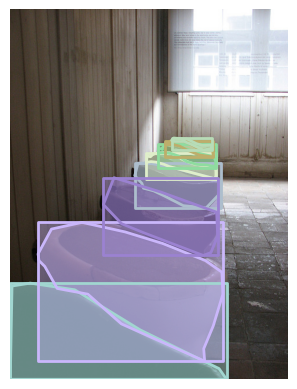

In [29]:
# Muestra una imagen aleatoria del dataset (de todo el conunto de evaluación)

def printImage(indexId):
    # Muestra la imagen con índice indexId
    img = coco.loadImgs(imgIds[indexId])[0]
    print(imgIds[indexId])
    I = io.imread(img['coco_url'])
    plt.imshow(I); plt.axis('off')
    annIds = coco.getAnnIds(imgIds=img['id'])
    anns = coco.loadAnns(annIds)
    coco.showAnns(anns, draw_bbox=True)
    
printImage(randint(len(imgIds)))

## Creamos nuestro propio dataset

COCO también tiene una API con la cual se puede manejar su dataset, sin embargo, nosotros no la usamos porque queremos ocupar un subconjunto personalizado del dataset; nosotros queremos trabajar solo con las imágenes que contengan un solo objeto, es por eso que decidimos crear nuestra propia clase CustomCocoDataset, que crea un dataset de las imágenes de COCO, pero filtrando solo las imágenes que contengan un solo objeto.

In [21]:
class CustomCocoDataset(Dataset):
    """
    Clase para hacer nuestro propio dataset personalizado.
    
    Obtenemos solo las imagenes que contengan un solo objeto del dataset de coco.
    """
    
    def __init__(self, ann_file, transform=None):
        self.transform = transform
        self.coco = COCO(ann_file)
        self.imgIds = coco.getImgIds()
        self.samples = []
        self.targets = []
        # Filtramos las imágenes que solo contienen un objeto
        for image_id in self.imgIds:
            anns = self.coco.imgToAnns[image_id]
            if len(anns) == 1:
                
                t = {}
                
                bbox = []
                xmin = anns[0]['bbox'][0]
                ymin = anns[0]['bbox'][1]
                xmax = xmin + anns[0]['bbox'][2]
                ymax = ymin + anns[0]['bbox'][3]
                bbox.append([xmin, ymin, xmax, ymax])
                bbox = torch.as_tensor(bbox, dtype=torch.float32)
                t['boxes'] = bbox
                t['labels'] = torch.ones((1,), dtype=torch.int64)
                t['image_id'] = torch.tensor(image_id)
                t['area'] = torch.tensor(anns[0]['area'])
                t['iscrowd'] = torch.tensor(anns[0]['iscrowd'])
                
                self.targets.append(t)
                self.samples.append((self.coco.loadImgs(image_id)[0])['coco_url'])

    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, index):
        target = self.targets[index]
        sample = Image.fromarray(io.imread(self.samples[index]))
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample, target

In [22]:
# Transformaciones para el pre-procesamiento
transform = transforms.Compose([
    # transforms.Resize((224, 224)),  # Re-escalado en caso de ser necesario
    transforms.ToTensor(),
    # Tal vez falte añadir más
])

In [23]:
# Creamos el dataset
coco_dataset = CustomCocoDataset(ann_file, transform)

long = coco_dataset.__len__()

print(f"\nLongitud del dataset: {long}")

"""
Dividimos nuestro dataset en entrenamiento y prueba, como ya está creado el dataset, la división la vamos a
lograr mediante los índices.
Dividimos en un 70% entrenamiento y un 30% prueba.
"""
index_train = int( long * .7 )

# Conjunto de entrenamiento
my_dataset_train = Subset(coco_dataset, list(range(0, index_train)))

# Tomamos solo 10 elementos del conjunto de entrenamiento para que no sea tan tardado
my_dataset_train = Subset(my_dataset_train, list(range(10)))

# Conjunto de prueba
my_dataset_test = Subset(coco_dataset, list(range(index_train+1, long-1)))

# Tomamos solo 10 elementos del conjunto de prueba para que no sea tan tardado
my_dataset_test = Subset(my_dataset_test, list(range(10)))

# Función necesaria
def collate_fn(batch):
    return tuple(zip(*batch))

# Tamaño de batch
bs = 1

# Dataloaders
data_loader_train = DataLoader(my_dataset_train, batch_size=bs, shuffle=True, num_workers=4, collate_fn=collate_fn)
data_loader_test = DataLoader(my_dataset_test, batch_size=1, shuffle=True, num_workers=4, collate_fn=collate_fn)

loading annotations into memory...
Done (t=1.11s)
creating index...
index created!

Longitud del dataset: 593


## Entrenamiento

Trabajar con imágenes es muy lento, y para poder programar y hacer pruebas de manera más eficiente, decidimos trabajar solo con 10 imágenes para el entrenamiento y 10 imágenes de prueba; el desempeño de la red va a verse muy afectado (negativamente), pero así podremos trabajar de forma eficiente. Si queremos un mejor entrenamiento, necesitamos entrenar con muchas más imágenes; pero esto va a costar mucho tiempo, incluso con 10 imágenes sentíamos que se tardaba mucho el entrenamiento. (En la exposición presentaremos resultados con más entrenamiento).

Además, a nosotros no nos interesa predecir la clase de los objetos todavía, es por ello que la variable num_classes=2 ; aunque COCO maneje muchas más clases, queremos acotar el problema lo más posible para poder enfocarnos en la tarea de detección de objetos.

In [24]:
def get_model_instance_segmentation(num_classes):
    # Cargamos un modelo pre-entrenado
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# 
num_classes = 2
epochs = 1
model = get_model_instance_segmentation(num_classes)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader_train)

lossgraph = []

for epoch in range(epochs):
    model.train()
    i = 0
    for imgs, annotations in data_loader_train:
        i += 1
        imgs = list(img for img in imgs)
        annotations = [{k: v for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        lossgraph.append(losses)
        print(f'Época: {epoch}, Avance: {i}/{len_dataloader}, Pérdida: {losses}')
        del(imgs)
        del(annotations)

Época: 0, Avance: 1/10, Pérdida: 0.7939348220825195
Época: 0, Avance: 2/10, Pérdida: 0.6825575828552246
Época: 0, Avance: 3/10, Pérdida: 0.38249534368515015
Época: 0, Avance: 4/10, Pérdida: 0.1900966763496399
Época: 0, Avance: 5/10, Pérdida: 0.31363025307655334
Época: 0, Avance: 6/10, Pérdida: 0.5119437575340271
Época: 0, Avance: 7/10, Pérdida: 0.47793832421302795
Época: 0, Avance: 8/10, Pérdida: 0.3180745840072632
Época: 0, Avance: 9/10, Pérdida: 0.30011576414108276
Época: 0, Avance: 10/10, Pérdida: 0.17782025039196014


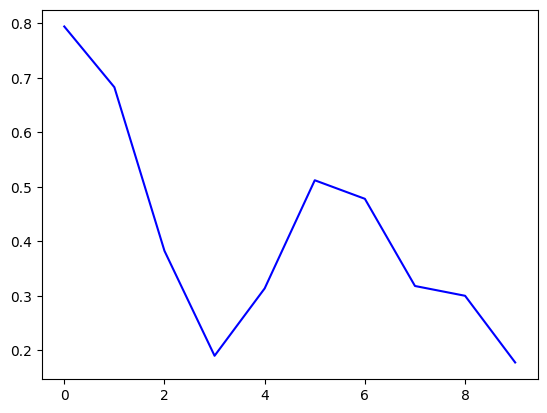

In [25]:
l = [tens.item() for tens in lossgraph]
#print(l)

plt.plot(list(range(len(l))), l, color='blue', label='pérdida')
plt.show()

## Evaluación

Después de realizar el entrenamiento es importante evaluar la red, para ello ocupamos el índice IOU, y lo medimos sobre nuestro dataset de prueba.  

A continuación también imprimimos una imagen para ver como predice cajas nuestra red, *hardcodeamos* la imágen con el id 724 porque pensamos que esa imagen ilustraba muy bien el desempeño de nuestro modelo.

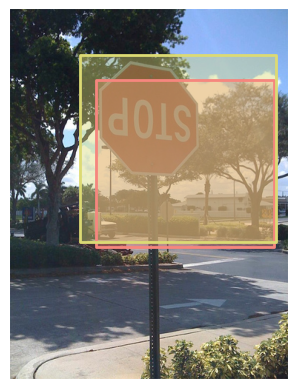

In [26]:
# Ejemplo de nuestro modelo con una imagen

IMG = coco.loadImgs(724)[0]
img = read_image(example_img)
img = img.to(dtype=torch.float32) / 255.0

# Ponemos el modelo en modo evaluación
model.eval()

# Usmaos torch.no_grad() para desactivar el cálculo del gradiente
with torch.no_grad():
    # Obtener las predicciones del modelo para la imagen
    pred = model([img])[0]

def pred_to_ann(pred):
    p = pred
    boxes = p['boxes'].tolist()
    labels = p['labels'].tolist()
    segmentation = [[],[]]
    ann = []
    for b in boxes:
        ann.append({'bbox': b, 'segmentation':segmentation})
    return ann

# Muestra la imagen con id imageId
I = io.imread(IMG['coco_url'])
plt.imshow(I); plt.axis('off')
anns = pred_to_ann(pred)
coco.showAnns(anns, draw_bbox=True)

### Calculamos el índice iou promedio sobre nuestro conjunto de datos

Por último a medida de métrica de evaluación calculamos el IOU promedio de nuestra red.

![Índice IOU](https://b2633864.smushcdn.com/2633864/wp-content/uploads/2016/09/iou_equation.png?lossy=2&strip=1&webp=1)

In [27]:
metric = IntersectionOverUnion()

k=0
prom = 0
for imgs, target in data_loader_test:
    k += 1
    k1 = model(imgs)
    m = metric(k1, target)['iou'].item()
    print(m)
    if np.isnan(m): continue
    prom += m
    #print(prom)
    del(imgs)
    del(target)

print(f"Índice iou promedio del dataset de prueba: {prom/k}")

nan
0.8363434076309204
nan
0.6562780141830444
0.6049538254737854
0.3247479200363159
nan
nan
0.5914129018783569
0.7534716129302979
Índice iou promedio del dataset de prueba: 0.3767207682132721
